<a href="https://colab.research.google.com/github/kap2fox/Intro-to-Robotics/blob/main/Robot_Navigation_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Моделируем движение в точку
Подключаем необходимы библиотеки.

In [ ]:
import numpy as np                                  # модуль для поддержки многомерных массивов
import matplotlib.pyplot as plt                     # модуль для визуализации данных
from scipy.integrate import odeint                  # модуль для оптимизации функций
import math as m                                    # модуль для математических функций

Задаем параметры и время.

In [ ]:
T_m = 0.08                                          # электромеханическая постоянная времени
k_e = 0.5                                           # конструктивная постоянная двигателя
n = 15001                                           # количество шагов моделирования
t = np.linspace(0,15,n)                             # задание пространства времени, массив n элементов значениями от 0 до 15 секунд
B = 0.15                                            # расстояние между колесами
r = 0.026                                           # радиус колеса

Описываем модель двигателя.

In [ ]:
def motor(state,t,u):
    speed, angle = state                            # обозначение состояния двигателя как скорости и угла поворота
    state_dt = [-speed/T_m + u/ (T_m * k_e), speed ]# задание производной состояния двигателя
    return state_dt

Указывавем начальные значения переменных.

In [ ]:
state_l = [0 , 0]                                   # переменная состояния левого двигателя
state_r = [0 , 0]                                   # переменная состояния правого двигателя
control_l = np.zeros(n)                             # массив управляющего напряжение левого двигателя
control_r = np.zeros(n)                             # массив управляющего напряжение правого двигателя
theta_l = np.zeros(n)                               # массив углов поворота левого двигателя
theta_r = np.zeros(n)                               # массив углов поворота правого двигателя
x = np.zeros(n)                                     # массив X координат робота
y = np.zeros(n)                                     # массив Y координат робота
path = np.zeros(n)                                  # массив пройденного пути
course = np.zeros(n)                                # массив значений курса робота
distance = np.zeros(n)                              # массив пройденной дистанции
bearing = np.zeros(n)                               # массив углов пеленга робота
courseAngle = np.zeros(n)                           # массив курсовых углов 
X_ref = -1                                          # координата X точки назначения
Y_ref = -1                                          # координата Y точки назначения
distance [0] = m.sqrt((X_ref)**2+(Y_ref)**2)        # задание начального значения дистанции
bearing [0] = m.atan2(Y_ref,X_ref)                  # задание начального значения пеленга

В целом, эта программа повторяет предыдущий вариант с вычислением местоположения робота, но здесь мы добавляем управляющее воздействие для движение в заданную точку. Для этого есть большое количество вариантов решения от простого П-регулятора до нелинейного закона управления. Можно решить эту здачу алгоритмически, снача повернуться на цель, а потом двигаться вперед, все зависит от контекста и окружающих препятствий.

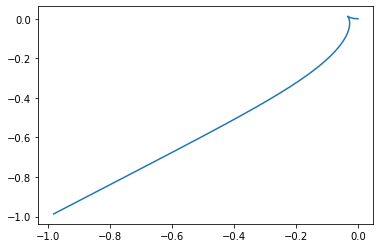

In [ ]:
for i in range(1,n):

    path[i] = (theta_r[i-1] + theta_l[i-1]) * r / 2                             # вычисление пройденного пути
    course[i] = (theta_r[i-1] - theta_l[i-1]) * r / B                           # вычисление угла поворота робота, его курса
    x[i] = x[i-1] + (path[i]-path[i-1]) * m.cos(course[i])                      # вычисление укоординаты X
    y[i] = y[i-1] + (path[i]-path[i-1]) * m.sin(course[i])                      # вычисление укоординаты Y
    distance [i] = m.sqrt((X_ref - x[i])**2+(Y_ref - y[i])**2)                  # вычисление расстояния до цели
    bearing [i] = m.atan2(Y_ref - y[i],X_ref - x[i])                            # вычисление угла на цель, пеленга
    courseAngle [i] = bearing [i] - course [i]                                  # вычисление курсового угла
    if courseAngle[i] > np.pi:
            courseAngle[i] = courseAngle[i] - 2 * np.pi
    if courseAngle[i] < -np.pi:
            courseAngle[i] = courseAngle[i] + 2 * np.pi                         # приведение курсового угла в диапазон [-pi, pi]

    #control_l [i] = 6 * np.cos (courseAngle [i]) * np.tanh(distance [i]) - 2 * (courseAngle [i])
    #control_r [i] = 6 * np.cos (courseAngle [i]) * np.tanh(distance [i]) + 2 * (courseAngle [i])
    control_l [i] = 4 * distance [i] - 4 * courseAngle [i]                      # вычисление управляющего напряжения левого двигателя
    control_r [i] = 4 * distance [i] + 4 * courseAngle [i]                      # вычисление управляющего напряжения правого двигателя
    if control_l[i] > 8:
            control_l[i] = 8
    if control_l[i] < -8:
            control_l[i] = -8
    if control_r[i] > 8:
            control_r[i] = 8
    if control_r[i] < -8:
            control_r[i] = -8                                                   # ограничение диапазона управляющего напряжения

    motor_l = odeint(motor, state_l,[t[i-1],t[i]],args=(control_l [i],))        # вычисление угла поворота левого двигателя
    state_l = motor_l[1,:]                                                      # запоминание состояния левого двигателя 
    theta_l[i] = motor_l[1,1]                                                   # сохранение угла поворота левого двигателя
    motor_r = odeint(motor, state_r,[t[i-1],t[i]],args=(control_r [i],))        # вычисление угла поворота правого двигателя
    state_r = motor_r[1,:]                                                      # запоминание состояния правого двигателя 
    theta_r[i] = motor_r[1,1]                                                   # сохранение угла поворота правого двигателя
    
plt.plot(x, y)